<a href="https://colab.research.google.com/github/ponvani/Bits/blob/master/DL_Assign1b_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DL Assignment Group: 70

Question No.1b. Sentiment Analysis dataset - 1.6 Million tweets.
<br>Ponvani(2018ac04559)
<br>Aparna(2018ac045)
<br>Poornima(2018ac045)

The description of the dataset says 0=negative 2=neutral 4=positive but there are no 2 labels in the entire dataset. Tracking the dataset back to its source, there are only 2 labels in the dataset. Please update the description.

**1. Import Libraries/Dataset (0.25 mark)**
<br>a. Import required libraries (recommended- use tensorflow/keras library).
<br>b. Import the dataset (use Google Drive if required).
<br>c. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [4]:
#a. Import required libraries (recommended- use tensorflow/keras library).

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns
sns.set(style='darkgrid')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#b. Import the dataset (use Google Drive if required).
import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv", names=['target', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
#c. Check the GPU available (recommended- use free GPU provided by Google Colab).
!nvidia-smi

Fri Oct 16 06:04:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 2. Data Visualization (0.25 mark)
 a. Print at least two tweets from each class of the dataset, for a sanity check that labels match the text. <br> b. Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries) <br> c. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.
<br> d. Print the shapes of train and test data

In [8]:
#a. Print at least two tweets from each class of the dataset, for a sanity check that labels match the text.

# check the number of positive vs. negative tagged sentences
positives = df['target'][df.target == 4]
negatives = df['target'][df.target == 0]
print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(df.shape[0]))


number of positve tagged sentences is:  800000
number of negative tagged sentences is: 800000
total length of the data is:            1600000


In [9]:
rec=df[df.target==0]
rec.head(2)

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [10]:
rec=df[df.target==4]
rec.head(2)

,target,id,date,query,user,text
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...


In [11]:
#b. Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets 
#belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries)
df['target'].value_counts().count

<bound method Series.count of 4    800000
0    800000
Name: target, dtype: int64>

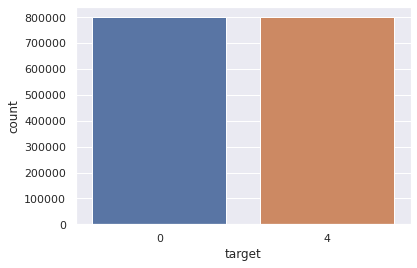

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="target", data=df)
plt.show()

In [ ]:
#c. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.

In [13]:
#d. Print the shapes of train and test data
from sklearn.model_selection import train_test_split
Y = df['target']
X = df.drop(columns=['target'])
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
print('X_train size {} , X_test size {}'.format(X_train.shape,X_test.shape))

X_train size (1120000, 5) , X_test size (480000, 5)


## 3. Data Pre-processing (0.25 mark)
 a. Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.
<br> b. Please use this pre-trained embedding layer from TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.
<br> c. Bring the train and test data in the required format

### Pre-Processing- Cleaning

**We are interested in the text and the target, so isolated these columns and assigned them to a new variable. **

In [23]:
table = df[['target', 'text']]
table[1:4]

,target,text
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire


In [25]:
import nltk
nltk.download('stopwords')

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+\S#+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

table.text = table.text.apply(lambda x: preprocess(x))
table=table.filter(['target','text'], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### After cleaning special charecters

In [28]:
table.head()

,target,text
0,0,"- awww, that's bummer. shoulda got david carr ..."
1,0,upset can't update facebook texting it... migh...
2,0,dived many times ball. managed save 50% rest g...
3,0,whole body feels itchy like fire
4,0,"no, behaving all. i'm mad. here? can't see there."


In [29]:
from sklearn.model_selection import train_test_split
Y = table['target']
X = table.drop(columns=['target'])
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
print('X_train size {} , X_test size {}'.format(X_train.shape,X_test.shape))

X_train size (1120000, 1) , X_test size (480000, 1)


b. Please use this pre-trained embedding layer from TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.


In [31]:
import tensorflow as tf
import tensorflow_hub as hub
embedded_text_feature_column = hub.text_embedding_column(
      key="text", 
      module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
embedded_text_feature_column


_TextEmbeddingColumn(key='text', module_spec_path='https://tfhub.dev/google/nnlm-en-dim128/1', trainable=False)

In [ ]:
 estimator = tf.estimator.DNNClassifier(
      hidden_units=[500, 100],
      feature_columns=[embedded_text_feature_column],
      n_classes=2,
      optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=X_train)
  test_eval_result = estimator.evaluate(input_fn=X_test)

  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]

In [ ]:
documents = [_text.split() for _text in table.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=5, 
                                            min_count=5, 
                                            workers=3)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 54855


In [ ]:
wordCloud=WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(words)


NameError: ignored

In [ ]:
words

dict_keys(['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', 'upset', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah', 'many', 'times', 'ball', 'managed', 'save', '50', 'rest', 'go', 'bounds', 'whole', 'body', 'feels', 'itchy', 'like', 'fire', 'behaving', 'mad', 'see', 'crew', 'need', 'hug', 'hey', 'long', 'time', 'yes', 'rains', 'bit', 'lol', 'fine', 'thanks', 'nope', 'que', 'spring', 'break', 'plain', 'city', 'snowing', 'pierced', 'ears', 'bear', 'watch', 'thought', 'ua', 'loss', 'embarrassing', 'counts', 'idk', 'either', 'never', 'talk', 'anymore', 'would', 'first', 'gun', 'really', 'though', 'zac', 'snyder', 'wish', 'miss', 'premiere', 'hollis', 'death', 'scene', 'hurt', 'severely', 'film', 'wry', 'directors', 'cut', 'file', 'taxes', 'ahh', 'ive', 'always', 'wanted', 'rent', 'love', 'soundtrack', 'oh', 'dear', 'drinking', 'forgotten', 'table', 'drinks', 'get', 'much', 'done', 'one', 'friend', 'called', 'asked', 'meet',

c. Bring the train and test data in the required format

In [ ]:
from sklearn.model_selection import train_test_split
Y = table['target']
X = table.drop(columns=['target'])
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print('X_train size {} , X_test size {}'.format(X_train.shape,X_test.shape))


X_train size (1120000, 1) , X_test size (480000, 1)


In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/3")
#embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim128/1")
#embeddings = embed.signatures(["cat is on the mat", "dog is in the fog"])
#embeddings


In [ ]:
embed1 = hub.load('https://tfhub.dev/google/nnlm-en-dim128/1')
#embed.signatures['default'](['my text', 'batch'])

### 4. Model Building (0.2*5 = 1 mark)
a. Sequential Model layers- Use AT LEAST 3 dense layers with appropriate input for each. Choose the best number for hidden units and give reasons.
<br> b. Add L2 regularization to all the layers.
<br> c. Add one layer of dropout at the appropriate position and give reasons.
<br> d. Choose the appropriate activation function for all the layers.
<br> e. Print the model summary.

In [ ]:
from keras.layers.core import Dense
model = Sequential()
model.add(Embedding(50000, 128, input_length=0))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(124, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
print(model.summary())

print('Train...')
#X_train,X_test,y_train,y_test
model.fit(X_train, y_train, batch_size=batch_size, epochs=2, validation_data=(X_test, y_test), verbose=2)

score, acc = model.evaluate(X_validate, Y_validate, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

NameError: ignored

### 5. Model Compilation (0.25 mark)
a. Compile the model with the appropriate loss function.
<br> b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.
<br> c. Use accuracy as metric.

### 6. Model Training (0.5 + 0.5 = 1 mark)
a. Train the model for an appropriate number of epochs (print the train and validation accuracy/loss for each epoch). Use the appropriate batch size.
<br> b. Plot the loss and accuracy history graphs. Print the total time taken for training.

### 7. Model Evaluation (0.25 + 0.75 = 1 mark)
a. Print the final test/validation loss and accuracy.
<br> b. Print confusion matrix and classification report for the validation dataset. Write a summary for the best and worst performing class and the overall trend.